In [3]:
# setting logging to print only error messages
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns 
from joblib import dump
from joblib import load
import time
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve

# Business Objective

Insurance is a risk-management technique used for hedging against various uncertain losses. It involves a contractual agreement between two parties in which one party promises to protect another party from uncertainties and losses.
We want to build a model that predicts the severity rating of vehicle accidents in the UK. This would allow the business determine the degree of accident severity per demography and geographical location within the UK and how much premium should be paid.
The predictive model will use Accident Severity as the Dependent Variable and Vehicle Type, Engine Capacity, Age of Vehicle as well as the demographic factors of the driver as the Independent Variables.

# Import training and testing set

In [4]:
trainset = pd.read_csv("trainset.csv")

testset = pd.read_csv("testset.csv")

In [5]:
trainset.shape

(80117, 27)

In [6]:
testset.shape

(20106, 27)

In [7]:
# checking first 5 rows for inspection
trainset.head()

,longitude,latitude,age_of_driver,engine_capacity_cc,age_of_vehicle,others,male,Small town,Urban area,Aug,...,Nov,Oct,Sept,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,accident_severity
0,-0.915724,-0.760740,0.699551,0.435414,-0.270062,-0.552275,0.675423,-0.31014,0.497338,-0.325987,...,-0.290249,-0.313825,-0.334356,-0.403737,-0.395673,-0.356298,-0.425856,-0.408305,-0.418838,Slight
1,0.794882,-0.707889,-1.327203,0.181216,0.962724,-0.552275,-1.480554,-0.31014,0.497338,-0.325987,...,-0.290249,-0.313825,-0.334356,-0.403737,2.527342,-0.356298,-0.425856,-0.408305,-0.418838,Slight
2,1.703353,-0.163372,0.545255,0.453881,-2.680711,-0.552275,-1.480554,-0.31014,0.497338,-0.325987,...,-0.290249,-0.313825,-0.334356,-0.403737,-0.395673,-0.356298,-0.425856,2.449151,-0.418838,Slight
3,-0.481895,0.791191,0.205402,0.566439,-0.515359,-0.552275,0.675423,-0.31014,0.497338,-0.325987,...,3.445316,-0.313825,-0.334356,-0.403737,-0.395673,2.806640,-0.425856,-0.408305,-0.418838,Serious
4,-0.080942,-1.134774,1.780927,0.424199,-2.680711,-0.552275,0.675423,-0.31014,0.497338,-0.325987,...,-0.290249,-0.313825,2.990821,-0.403737,-0.395673,-0.356298,-0.425856,-0.408305,2.387557,Serious


In [8]:
#checking all variables are avaible and no missing values
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80117 entries, 0 to 80116
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           80117 non-null  float64
 1   latitude            80117 non-null  float64
 2   age_of_driver       80117 non-null  float64
 3   engine_capacity_cc  80117 non-null  float64
 4   age_of_vehicle      80117 non-null  float64
 5   others              80117 non-null  float64
 6   male                80117 non-null  float64
 7   Small town          80117 non-null  float64
 8   Urban area          80117 non-null  float64
 9   Aug                 80117 non-null  float64
 10  Dec                 80117 non-null  float64
 11  Feb                 80117 non-null  float64
 12  Jan                 80117 non-null  float64
 13  July                80117 non-null  float64
 14  June                80117 non-null  float64
 15  Mar                 80117 non-null  float64
 16  May 

In [9]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20106 entries, 0 to 20105
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20106 non-null  float64
 1   latitude            20106 non-null  float64
 2   age_of_driver       20106 non-null  float64
 3   engine_capacity_cc  20106 non-null  float64
 4   age_of_vehicle      20106 non-null  float64
 5   others              20106 non-null  float64
 6   male                20106 non-null  float64
 7   Small town          20106 non-null  float64
 8   Urban area          20106 non-null  float64
 9   Aug                 20106 non-null  float64
 10  Dec                 20106 non-null  float64
 11  Feb                 20106 non-null  float64
 12  Jan                 20106 non-null  float64
 13  July                20106 non-null  float64
 14  June                20106 non-null  float64
 15  Mar                 20106 non-null  float64
 16  May 

Before we begin building our models we need to split our train and test sets into predictors(x's) and traget(y) variables.

In [10]:
# drop accident severity for X-training set, but keep all others
Xtrain = trainset.drop("accident_severity", axis=1)
ytrain = trainset["accident_severity"].copy()

# drop accidenent severity for X-testing set, but keep all others
Xtest = testset.drop("accident_severity", axis=1)
ytest = testset["accident_severity"].copy()

# Feature selection

Since we have 26 predictors, it would be a good idea to extract the important features and exclude the least important ones. This way our models will get simplified and can understand better the most associate ones and get better results. 
I will use random forest classifier which is an embedded method and it works in finding which predictors are most signigicant in predicting the target varibale accurately.  

In [11]:
#Since our target is not balanced i am assigning the class_weight parameter to blanced which will assign weights to 
#the classes in order to make them balanced
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced")

param_grid = {
        'n_estimators': [10,100,200],
        'max_depth': [3, 5, 15]
}


# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                              scoring='accuracy',return_train_score=True, n_jobs=-1)

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 70.01977133750916 seconds


In [12]:
#Best estimators from the grid search 
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200)

In [13]:
#check the average accuracy over the five k-fold 
grid_search.best_score_

0.764856410073774

The best tuned model from the given parameter acheived an accuracy score of ***76.48%***

In [14]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

latitude: 0.18065876267303543
longitude: 0.17082648116201668
engine_capacity_cc: 0.1506186200995754
age_of_driver: 0.12810564602565944
age_of_vehicle: 0.10239870783881648
Urban area: 0.022593926540512933
male: 0.021206219070971106
others: 0.02035016065798285
Saturday: 0.013815921493145781
Thursday: 0.013450942844872306
Wednesday: 0.013369004906142871
Tuesday: 0.013321059722591587
Sunday: 0.013142748667712282
Monday: 0.013033077153904471
Aug: 0.011704088429706305
Jan: 0.011520279972176256
Feb: 0.011351876188712235
July: 0.011205866103736932
Oct: 0.010603212877708228
Sept: 0.010485964725361317
Small town: 0.009946471673170965
Mar: 0.009781369739866326
Dec: 0.009440039981519344
June: 0.00929797379954781
Nov: 0.00905875467935252
May: 0.0087128229722022


After using the feature_importance_ attribue to extract the feature importance, we can see that latitude, longitude, engine_capacity_cc,age_of_driver, Urban area are most predictores that contributed in predicting the target variable accurately.
The rest have very little contribution.

<AxesSubplot:xlabel='Features', ylabel='Importances'>

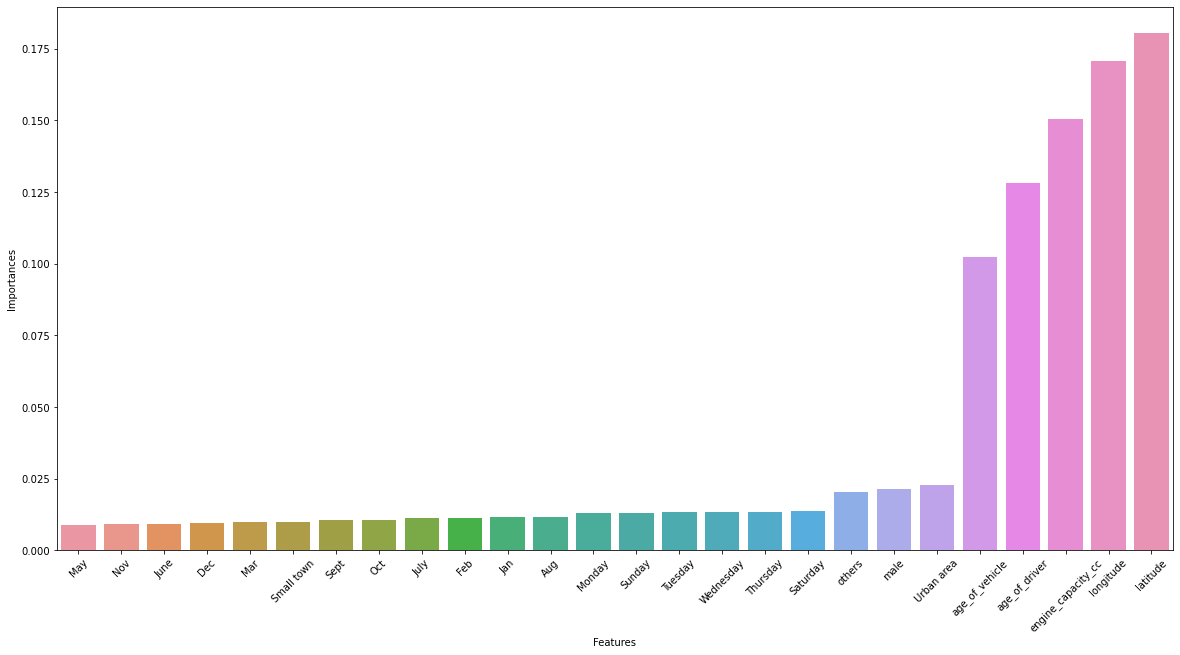

In [15]:
# Vizualising feature importance on a bar graph
df = pd.DataFrame({"Features": Xtrain.columns, "Importances":feature_importances})
df.set_index('Importances')

# sort in ascending order to better visualization.
df = df.sort_values('Importances')

# plot the feature importances in bars.
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.barplot(x="Features",y= "Importances", data=df)

I will extract the top 10 important predictors and and leave the others. This way way the moodel can perform better and compute faster

In [17]:
#selecting the top 10 features
Xtrain=Xtrain[["latitude","longitude","engine_capacity_cc","age_of_driver","age_of_vehicle","Urban area","male","others",
               "Saturday","Thursday"]]

In [18]:
#applying it to testing set as well
Xtest=Xtest[Xtrain.columns]

In [19]:
#checking the 10 variables were extracted
Xtest.shape

(20106, 10)

In [20]:
Xtrain.shape

(80117, 10)

# Baseline

We'll use a majority class classifier as a baseline, i.e., we will find out what is the most common class label in the training set and always output it as a prediction

In [19]:
# the number of instances belonging to each class
ytrain.value_counts()

Slight     63476
Serious    15329
Fatal       1312
Name: accident_severity, dtype: int64

In [20]:
# total size of the training set
ytrain.shape[0]

80117

The baseline classifier will output "Slight" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Slight" label, the accuracy measures will be:

* Precision: 63476/80117 = 0.792

* Recall: 63476/63476 = 1.0

* F-score: 2/(1/0.792 + 1/1.0) = 0.887

For the "Serious" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/15329 = 0.0

* F-score: 0.0

For the "Fatal" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/1312 = 0.0

* F-score: 0.0

The averages of the three classes, i.e. the eventual baseline scores:

* **Precision: 0.264**

* **Recall: 0.333**

* **F-score: 0.296**

# Hyperparameter Tuning and Modeling

We are now going to tune hyperparameters for different models on the training set, to get the best possible model to use on the testing set. However, due to the size o the data set and the computational power available to me, i have chosen the following methods to get the best following models while reducing computational power:
* Logistic Regression (used weights to balance my data)
* Decision Tree (used weights to balance my data)
* Decision Tree Oversampling
* Logistic Regression Oversampling
* XGBoost Classifier
* Random forest (used weights to balance my data)
* Random forest (oversampling)

## Logistic Regression using weight balance

In imblanced traget variables algorithms tend to disregard  minority classes and focuse on the dominant one. In order to avoid this we are going to apply weights to our classes in order to balances our target variable.

In [155]:
# define models and parameter and applying weights to our classes by assigning 
#class_weight="balanced" to balances it out. 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced",multi_class='multinomial')
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty,C=c_values)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1_macro',error_score=0,return_train_score=True)
start = time.time()
#Fit the mode
grid_search_lr.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 6.896375894546509 seconds


In [156]:
grid_search_lr.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [157]:
grid_search_lr.best_score_

0.3110816331973612

The best tuned model proved to be C=0.1 and it achievd an F-score of **31.1%** which is an improvement of the baseline. However, its not high enough to be used for a model

In [158]:
best_model_index = grid_search_lr.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

3

In [159]:
log_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_lr.cv_results_[f"split{x}_test_score"][best_model_index]
    log_split_test_scores.append(val)

We can see the difference between train and test mean score is too low, which show no over fitting has osccured in the model

In [160]:
cv_results = pd.DataFrame(grid_search_lr.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'C': 0.1, 'penalty': 'l2'}",0.311396,0.311082,0.100854
1,"{'C': 10, 'penalty': 'l2'}",0.311406,0.311068,0.108563
2,"{'C': 1.0, 'penalty': 'l2'}",0.311395,0.311068,0.104816
0,"{'C': 100, 'penalty': 'l2'}",0.311406,0.311060,0.111297
4,"{'C': 0.01, 'penalty': 'l2'}",0.311350,0.311043,0.098696


In [161]:
#saving the model
dump(grid_search_lr.best_estimator_, 'models/lr.joblib')

['models/lr.joblib']

## Logistic regression oversampling

Instead of assigning weights to the classes to balance it, we are going to use another balancing method called oversampling. what it does is it increases the number of sampling in the minority classes to match up with number of classes in the majority class 

In [113]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
#checking initially number of records in each class
unique, count= np.unique(ytrain,return_counts=True)
ytrain_dict_value_count={k:v for (k,v) in zip(unique, count)}
ytrain_dict_value_count

{'Fatal': 1312, 'Serious': 15329, 'Slight': 63476}

In [115]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy={'Slight':63476, 'Serious':63476, 'Fatal':63476})
# fit and apply the transform
Xtrain_oslr, ytrain_oslr = over.fit_resample(Xtrain, ytrain)
#  check new class distribution
print(Counter(ytrain_oslr))

Counter({'Slight': 63476, 'Serious': 63476, 'Fatal': 63476})


In [118]:
from sklearn.linear_model import LogisticRegression
lr_os = LogisticRegression(multi_class='multinomial')
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty,C=c_values)
grid_search_oslr = GridSearchCV(estimator=lr_os, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1_macro',error_score=0,return_train_score=True)
start = time.time()
#Fit the mode
grid_search_oslr.fit(Xtrain_oslr, ytrain_oslr)
end = time.time() - start
print(f"Took {end} seconds")

Took 29.196069478988647 seconds


In [121]:
grid_search_oslr.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [122]:
grid_search_oslr.best_score_

0.40974117345184957

The best tuned model proved to be C=0.01 and it achievd an F-score of **40.97%** which is nearly 10% improvement from previous method.

In [123]:
cv_results = pd.DataFrame(grid_search_oslr.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
4,"{'C': 0.01, 'penalty': 'l2'}",0.409956,0.409741,0.052282
3,"{'C': 0.1, 'penalty': 'l2'}",0.409999,0.409717,0.068715
0,"{'C': 100, 'penalty': 'l2'}",0.409909,0.409574,0.081862
1,"{'C': 10, 'penalty': 'l2'}",0.409909,0.409574,0.081862
2,"{'C': 1.0, 'penalty': 'l2'}",0.409910,0.409574,0.082125


In [138]:
#saving the model
dump(grid_search_oslr.best_estimator_, 'models/lros.joblib')

['models/lros.joblib']

## Decision Tree using weight balance

In [163]:
from sklearn.tree import DecisionTreeClassifier
# define models and parameter and applying weights to our classes by assigning class_weight="balanced"
dt = DecisionTreeClassifier(class_weight="balanced",random_state=7)
criterion = ['gini',"entropy"]
max_depth = [10,50,100]
max_features=["auto","sqrt",None]
# define grid search
grid = dict(criterion=criterion,max_depth=max_depth,max_features=max_features)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=grid, n_jobs=-1, cv=5, scoring='f1_macro',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_dt.fit(Xtrain, ytrain)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

Took 15.150352478027344 seconds


In [164]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=50, random_state=7)

In [165]:
grid_search_dt.best_score_

0.3638780120012578

The best tuned model the grid search got is max_depth=50 and it achievd an F-score of **36.38%** which is a slight decrease in improvment from logistic regression using oversampling method

In [166]:
#extracting index number for the best achieved model
best_model_index = grid_search_dt.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

5

In [167]:
dt_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_dt.cv_results_[f"split{x}_test_score"][best_model_index]
    dt_split_test_scores.append(val)

In [168]:
cv_results = pd.DataFrame(grid_search_dt.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'criterion': 'gini', 'max_depth': 50, 'max_features': None}",0.999970,0.363878,63.611094
8,"{'criterion': 'gini', 'max_depth': 100, 'max_features': None}",0.999970,0.363878,63.611094
14,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': None}",0.999963,0.360550,63.943646
17,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': None}",0.999970,0.360288,63.970089
13,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt'}",0.999970,0.358504,64.148464
16,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt'}",0.999970,0.358504,64.148464
15,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto'}",0.999970,0.358504,64.148464
12,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto'}",0.999970,0.358504,64.148464
3,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto'}",0.999970,0.353620,64.636961
4,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt'}",0.999970,0.353620,64.636961


We can see our decision tree model tends to overfit in our traning data, losing its ablilty to perform well on new unseen data set.It tend to overfit as the max_depth increases over 10. We can see the model is overfitting at max_depth= 50 and 100. Even though the best model is acheived at max_depth=50, the score is not better than logistic oversampling

In [169]:
#saving the model
dump(grid_search_dt.best_estimator_, 'models/dt.joblib')

['models/dt.joblib']

## Decision Tree oversampling

In [126]:
#checking initially number of records in each class
unique, count= np.unique(ytrain,return_counts=True)
ytrain_dict_value_count={k:v for (k,v) in zip(unique, count)}
ytrain_dict_value_count

{'Fatal': 1312, 'Serious': 15329, 'Slight': 63476}

In [127]:
# oversampling strategy
over = RandomOverSampler(sampling_strategy={'Slight':63476, 'Serious':63476, 'Fatal':63476})
# fit and apply the transform
Xtrain_osdt, ytrain_osdt = over.fit_resample(Xtrain, ytrain)
#  check new class distribution
print(Counter(ytrain_osdt))

Counter({'Slight': 63476, 'Serious': 63476, 'Fatal': 63476})


In [151]:
from sklearn.tree import DecisionTreeClassifier
dt_os = DecisionTreeClassifier(random_state=7)
criterion = ['gini',"entropy"]
max_depth = [10,50,100]
max_features=["auto","sqrt",None]
# define grid search
grid = dict(criterion=criterion,max_depth=max_depth,max_features=max_features)
grid_search_dtos = GridSearchCV(estimator=dt_os, param_grid=grid, n_jobs=-1, cv=5, scoring='f1_macro',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_dtos.fit(Xtrain_osdt, ytrain_osdt)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

Took 68.98468661308289 seconds


In [152]:
grid_search_dtos.best_estimator_

DecisionTreeClassifier(max_depth=50, max_features='auto', random_state=7)

In [153]:
grid_search_dtos.best_score_

0.9190295049163915

The best tuned model the grid search got is max_depth=50 and it achievd an F-score of **91.9%** which is a major improvement from the previous models we used so far, this is very encouraging

In [154]:
cv_results = pd.DataFrame(grid_search_dtos.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto'}",0.999984,0.919030,8.095602
4,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt'}",0.999984,0.919030,8.095602
6,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto'}",0.999984,0.919030,8.095602
7,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt'}",0.999984,0.919030,8.095602
16,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt'}",0.999984,0.917181,8.280455
15,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto'}",0.999984,0.917181,8.280455
12,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto'}",0.999984,0.917181,8.280455
13,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt'}",0.999984,0.917181,8.280455
14,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': None}",0.999949,0.917176,8.277699
17,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': None}",0.999984,0.917141,8.284465


slight overfitting occured using oversampling method, however it much lower than the previous decision tree model while using a blancing method which is very encouraging, and it appears that oversampling methods are producing much better results than adding weights to our classes.

In [155]:
#saving the model
dump(grid_search_dtos.best_estimator_, 'models/dtos.joblib')

['models/dtos.joblib']

## XGBoost classifier

This is a new model that i have learned about it online, going to try it out and see if it gives good results

In [102]:
from xgboost import XGBClassifier
# define models and parameter
xgb = XGBClassifier(random_state=7)
loss = ['deviance',"exponential"]
n_estimators = [200,300]
max_depth=[15,20]
# define grid search
grid = dict(loss=loss,n_estimators=n_estimators,max_depth=max_depth)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=grid, n_jobs=-1, cv=5, scoring='f1_macro',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_xgb.fit(Xtrain, ytrain)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Took 1520.2628057003021 seconds


In [103]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              loss='deviance', max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
grid_search_xgb.best_score_

0.3660045343683682

The best tuned model the grid search got is max_depth=15 and n_estimator=300.It achievd an F-score of **36.6%** which is much lower than what we have gotten in our previous models. Not going to hypertune anymore since its taking alot of computational power to run this model

In [105]:
best_model_index = grid_search_xgb.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

1

In [106]:
dt_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_xgb.cv_results_[f"split{x}_test_score"][best_model_index]
    dt_split_test_scores.append(val)

In [107]:
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'loss': 'deviance', 'max_depth': 15, 'n_estimators': 300}",0.999716,0.366005,63.389163
5,"{'loss': 'exponential', 'max_depth': 15, 'n_estimators': 300}",0.999716,0.366005,63.389163
3,"{'loss': 'deviance', 'max_depth': 20, 'n_estimators': 300}",0.999970,0.363482,63.650706
7,"{'loss': 'exponential', 'max_depth': 20, 'n_estimators': 300}",0.999970,0.363482,63.650706
0,"{'loss': 'deviance', 'max_depth': 15, 'n_estimators': 200}",0.996662,0.361279,63.751085
4,"{'loss': 'exponential', 'max_depth': 15, 'n_estimators': 200}",0.996662,0.361279,63.751085
2,"{'loss': 'deviance', 'max_depth': 20, 'n_estimators': 200}",0.999966,0.360301,63.968668
6,"{'loss': 'exponential', 'max_depth': 20, 'n_estimators': 200}",0.999966,0.360301,63.968668


We can see the model is overfitting, therefore no need to tune our parameters since it will give out similar results.

In [98]:
#saving the model
dump(grid_search_xgb.best_estimator_, 'models/xgb.joblib')

['models/xgb.joblib']

## Random Forest Using weight balance

Since in our first random forest model that we did for feature selection, our best tuned model that the grid search has achieved were the highest parameters we specified for max_depth=15 and n_estimators=200. Therefore, I will increase the parameters for this new random forest and see if it the grid search take higher parameters for higher results. 

In [132]:
from sklearn.ensemble import RandomForestClassifier
# define models and parameter and applying weights to our classes by assigning class_weight="balanced"
rf = RandomForestClassifier(random_state=7,class_weight="balanced")

# specify the hyperparameters and their values
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15,20],
     'criterion': ["gini", "entropy"],
    'min_samples_split': [5, 10]
   
}

# we'll use 5-fold cross-validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_rf.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 506.3693974018097 seconds


In [133]:
grid_search_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=10, n_estimators=200,
                       random_state=7)

In [134]:
grid_search_rf.best_score_

0.3901102013431216

The best tuned model the grid search got is max_depth=15, criterion=entropy, and n_estimator=300.It achievd an F-score of **39%** which is better than the first random forest we ran for feature selection,nevertheless it procued way lower than our previous models. However, i will try to run a new model with higher n_estmator parameter and see if it scores higher.

In [137]:
cv_results = pd.DataFrame(grid_search_rf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
10,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.825728,0.390110,52.755619
11,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}",0.825951,0.388896,52.915305
3,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}",0.841191,0.388392,53.828288
2,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.840051,0.387886,53.825946
8,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.852424,0.379325,55.500430
9,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 300}",0.855144,0.377904,55.808175
1,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 300}",0.872226,0.377551,56.714055
0,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.870130,0.375997,56.788359
6,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}",0.958394,0.365742,61.837986
15,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}",0.959366,0.365527,61.899161


In [138]:
# put them into a separate variable for convenience
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

latitude: 0.22943670901107488
longitude: 0.22176630546640044
engine_capacity_cc: 0.17546788558460014
age_of_driver: 0.15793543002351476
age_of_vehicle: 0.12093444659607928
Urban area: 0.020686617585852503
male: 0.019834029366147313
others: 0.01859988514386048
Saturday: 0.017769982090665954
Thursday: 0.017568709131804264


I will increase the parameter for n_estimator and see if it gives me a higher score

In [139]:
rf2 = RandomForestClassifier(random_state=7,class_weight="balanced")

# specify the hyperparameters and their values
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [15,20],
     'criterion': ["gini", "entropy"],
    'min_samples_split': [5, 10]
   
}

# we'll use 5-fold cross-validation
grid_search_rf2 = GridSearchCV(rf2, param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_rf2.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 728.5338225364685 seconds


In [141]:
grid_search_rf2.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=10, n_estimators=400,
                       random_state=7)

In [142]:
grid_search_rf2.best_score_

0.38941607398386713

The model took the same parameters as before but higher n_estimator as optimal ones for acheiving the best possible score.No improvement is shown while increasing the the parameters. Therefore we will stick with the first random forest model.

In [143]:
cv_results = pd.DataFrame(grid_search_rf2.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
11,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 400}",0.828104,0.389416,52.974956
10,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}",0.825951,0.388896,52.915305
3,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 400}",0.842938,0.388474,53.914223
2,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}",0.841191,0.388392,53.828288
9,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 400}",0.856704,0.379070,55.752505
8,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 300}",0.855144,0.377904,55.808175
0,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 300}",0.872226,0.377551,56.714055
1,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 400}",0.874561,0.376232,56.980435
7,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 400}",0.960011,0.366150,61.859772
14,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}",0.959366,0.365527,61.899161


We can see how the model is overfitting. As we keep increasing the value of this parameter, test accuracy remains the
same or gets worse, but the training accuracy keeps increasing. It means that our random forest tree model keeps learning about the training data better and better with an increase in max_depth and n_estimator but the performance on test data is not improving at all,therefore i will stick with the first one.

In [170]:
#saving the previous best model    
dump(grid_search_rf.best_estimator_, 'models/rf.joblib')

['models/rf.joblib']

## Random Forest OverSampling

In [32]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
#checking initially number of records in each class
unique, count= np.unique(ytrain,return_counts=True)
ytrain_dict_value_count={k:v for (k,v) in zip(unique, count)}
ytrain_dict_value_count

{'Fatal': 1312, 'Serious': 15329, 'Slight': 63476}

In [33]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy={'Slight':63476, 'Serious':63476, 'Fatal':63476})
# fit and apply the transform
Xtrain_os, ytrain_os = over.fit_resample(Xtrain, ytrain)
#  check new class distribution
print(Counter(ytrain_os))


Counter({'Slight': 63476, 'Serious': 63476, 'Fatal': 63476})


In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_os = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
param_grid = {
    'n_estimators': [300,400],
    'max_depth': [20,25],
     'criterion': ["gini", "entropy"],
    'min_samples_split': [5, 10]
   
}

# we'll use 5-fold cross-validation
grid_search_rf_os = GridSearchCV(rf_os, param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search_rf_os.fit(Xtrain_os, ytrain_os)
end = time.time() - start
print(f"Took {end} seconds")

Took 1831.012992143631 seconds


In [35]:
grid_search_rf_os.best_estimator_

RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=400,
                       random_state=7)

In [36]:
grid_search_rf_os.best_score_

0.9661213884969759

The best tuned model the grid search got is max_depth=25 and n_estimators=400.It achievd an F-score of **96.6%** which is the highest we got so far. Since its taking alot of computaional power and time to run the model i wont be tuning my parameters anymore for random forest. 

In [69]:
cv_results = pd.DataFrame(grid_search_rf_os.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 400}",0.998464,0.966121,3.239235
4,"{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 300}",0.998392,0.965568,3.287667
13,"{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 400}",0.998535,0.964942,3.364221
12,"{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 300}",0.998502,0.964853,3.369963
15,"{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 400}",0.994634,0.950870,4.400069
7,"{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 400}",0.994072,0.950214,4.411998
14,"{'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 300}",0.994448,0.950123,4.457277
6,"{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 300}",0.993963,0.949939,4.429136
1,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}",0.986338,0.941917,4.503611
0,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}",0.986084,0.941690,4.502032


It can be see that no overfitting occured this time, the difference between the train and validation score are close to each other

In [70]:
#saving the previous best model    
dump(grid_search_rf_os.best_estimator_, 'models/rf_os.joblib')

['models/rf_os.joblib']

# Model Evaluation

After running and tuning the four models and getting the best possible scores, we will begin evaluating the models on unseen data and see how they perform.

In [139]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score, precision_score, recall_score
from joblib import load
# logestic regression
best_lr = load("models/lr.joblib")
# Logistic regression oversampling
best_lros = load("models/lros.joblib")
#decision tree
best_dt = load("models/dt.joblib")
#decision tree oversampling
best_dtos = load("models/dtos.joblib")
#random forest
best_rf = load('models/rf.joblib')
#random forest using oversampling
best_rf_os = load('models/rf_os.joblib')
# xgboost classifier
best_xgb = load('models/xgb.joblib')

## Logistic Regression Evaluation(assigning weight)

In [144]:
# macro-averaged precision, recall and f-score
y_hat_lr = best_lr.predict(Xtest)
print(classification_report(ytest,y_hat_lr))

              precision    recall  f1-score   support

       Fatal       0.03      0.51      0.05       310
     Serious       0.23      0.19      0.21      3814
      Slight       0.83      0.56      0.67     15982

    accuracy                           0.49     20106
   macro avg       0.36      0.42      0.31     20106
weighted avg       0.70      0.49      0.57     20106



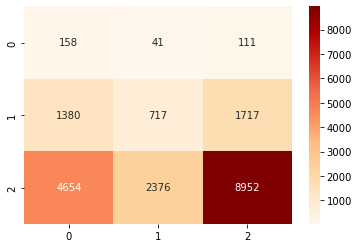

In [66]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_lr)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

The logistic regression model achieved an F-score of **31%** on the testing set which is similar to the score we got on the training set. By looking at the confusion matrix and recall we can see that the model is retrieving low recall score for serious compared to fatal and slight.

## Logistic Regression Oversampling Evaluation

In [145]:
# macro-averaged precision, recall and f-score
y_hat_lros = best_lros.predict(Xtest)
print(classification_report(ytest,y_hat_lros))

              precision    recall  f1-score   support

       Fatal       0.03      0.51      0.05       310
     Serious       0.23      0.19      0.21      3814
      Slight       0.83      0.56      0.67     15982

    accuracy                           0.49     20106
   macro avg       0.36      0.42      0.31     20106
weighted avg       0.70      0.49      0.57     20106



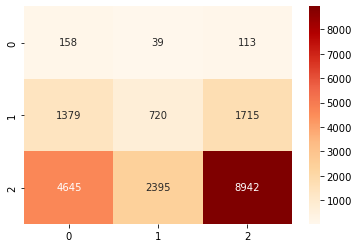

In [142]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_lros)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

 Using oversampling, it achieved an F-score of **31%** on the testing which is the exact same result as applying weights. It has'nt improved the results, even though it has achived a higher score on the training set with very low overfitting

## Decision Tree Evaluation (Assigning weights)

In [25]:
# macro-averaged precision, recall and f-score
y_hat_dt = best_dt.predict(Xtest)
print(classification_report(ytest,y_hat_dt))

              precision    recall  f1-score   support

       Fatal       0.07      0.07      0.07       310
     Serious       0.24      0.25      0.25      3814
      Slight       0.81      0.80      0.81     15982

    accuracy                           0.69     20106
   macro avg       0.37      0.37      0.37     20106
weighted avg       0.69      0.69      0.69     20106



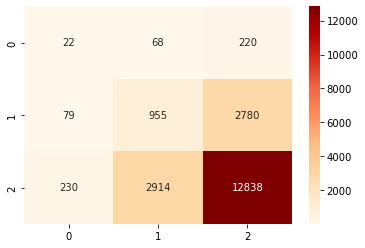

In [65]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_dt)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

The decision tree model achieved an F-score of **37%** on the testing set which is similar to the score we got on the training set as well and it had achieved a better score that logistic. By looking at the recall and confusion matrix, it can be seen that it achived a very low score in predicting correctly for fatal and serious.

## Decision Tree Oversampling Evaluation

In [143]:
# macro-averaged precision, recall and f-score
y_hat_dtos = best_dtos.predict(Xtest)
print(classification_report(ytest,y_hat_dtos))

              precision    recall  f1-score   support

       Fatal       0.04      0.05      0.04       310
     Serious       0.21      0.20      0.21      3814
      Slight       0.80      0.81      0.81     15982

    accuracy                           0.68     20106
   macro avg       0.35      0.35      0.35     20106
weighted avg       0.68      0.68      0.68     20106



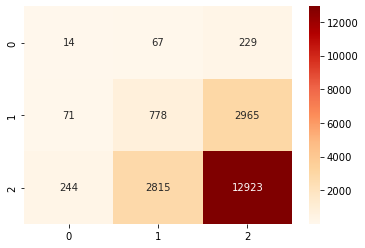

In [159]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_dtos)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

Unfortunately, with ooversampling the model achieved very similar results to previous balancing method. This was very unexpected since it has achieved a very high score of 91.2% in the training set with moderate overfitting compared to the balancing approach.

## XGBoost Evaluation

In [110]:
# macro-averaged precision, recall and f-score
y_hat_xgb = best_xgb.predict(Xtest)
print(classification_report(ytest,y_hat_xgb))

              precision    recall  f1-score   support

       Fatal       0.44      0.01      0.03       310
     Serious       0.45      0.10      0.17      3814
      Slight       0.81      0.97      0.88     15982

    accuracy                           0.79     20106
   macro avg       0.57      0.36      0.36     20106
weighted avg       0.73      0.79      0.73     20106



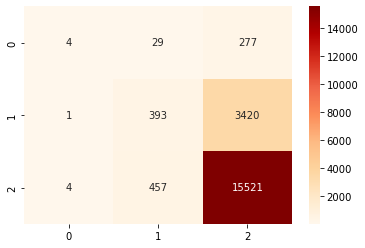

In [111]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_xgb)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

XGBoost model achieved an F-score of **36%** on the testing set which is similar to the score we got on the training set as well.By looking at the confusion matrix and recall we can see that the model is retrieving the lowest recall values so far for fatal and serious, which are important classes to predict for our business objective

## Random Forest Evaluation (Assigning weights)

In [27]:
# macro-averaged precision, recall and f-score
y_hat_rf = best_rf.predict(Xtest)
print(classification_report(ytest,y_hat_rf))

              precision    recall  f1-score   support

       Fatal       0.06      0.05      0.05       310
     Serious       0.31      0.26      0.28      3814
      Slight       0.82      0.85      0.84     15982

    accuracy                           0.73     20106
   macro avg       0.40      0.39      0.39     20106
weighted avg       0.71      0.73      0.72     20106



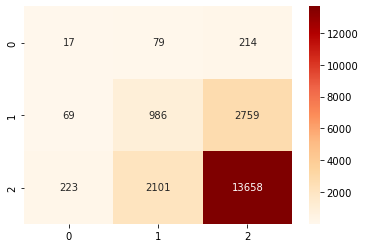

In [67]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_rf)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

The random forest model achieved an F-score of **39%** on the testing set which is similar to the score we got on the training set as well.This is the highest score recieved so far out of the models. However it produced so far the lowest recall score for fatal.

## Random Forest Evaluation (OverSampling)

In [74]:
# macro-averaged precision, recall and f-score
y_hat_rf_os = best_rf_os.predict(Xtest)
print(classification_report(ytest,y_hat_rf_os))

              precision    recall  f1-score   support

       Fatal       0.25      0.01      0.02       310
     Serious       0.35      0.12      0.18      3814
      Slight       0.81      0.95      0.87     15982

    accuracy                           0.78     20106
   macro avg       0.47      0.36      0.36     20106
weighted avg       0.71      0.78      0.73     20106



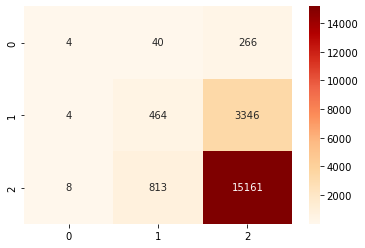

In [75]:
# 0:fatal, 1:serious, 2:slight
matrix = confusion_matrix(ytest, y_hat_rf_os)
plot = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="OrRd" ,fmt='g')

The random forest model using oversampling achieved and F-score of **36%** on the testing set which is considerably lower than the score it achieved on the training set. It also achieved a bit worse than the previous random forset using weights methods. Moreover by looking at confusion matrix/ recall score we can see it achieved a very low score for fatal and serious, which are important classes for our business problem to have high score in them 

# Conclusion

All our models acieved very smiliar results and they all performed better than our baseline, random forest using weighted balanced method achieved the highest out of all however it has achieved a lower recall score for fatal and serious. 
Since our problem objective is to be able to give the right insurance package for people in order for the insurance company to generate better revenue and save money, we would be more interested in achiveing a better recall values. Therefore, if i had to choose the best model to deploy for the company i would go for multinomial logistic regression, since it had produced the best recall score for serious and fatal, since these two are critical in prediciting correctly since it would cost the insurance company the most in terms of money if they deployed the wrong/cheaper package to customers.

# Possible Future Improvments

* Since we had an unbalanced data, it would be a good idea to instances for our minority classes such as fatal and serious.
* Having machines with higher computational power would have allowed us to try out different models that requires huge computational power.
* Having more parameters related to potenital accident severity could help our models understand the relationships better and predict more accurately
* Come up with more possible feature engineering to create a stronger associations with the traget.
* Treating outlier could have improved the model in understand the predictors better.

